## Watershed mapping

This notebook is used to generate a map of the watershed for a specific gauge.  Remember that a *watershed* is area that drains to a certain point.  

For our gauges, the watershed will include all of the rivers that are upstream of the gauge. 

Enter your gauge station ID below to get started!


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pygeohydro as gh
from pygeohydro import NWIS
from pynhd import NLDI

In [99]:
station_id = "04249000"

# If you'd like, you can add the coordinates of your gage, 
# then we can add a dot on the final map to represent your gage.
coordinates = [-76.996634, 41.23618985]


<Axes: >

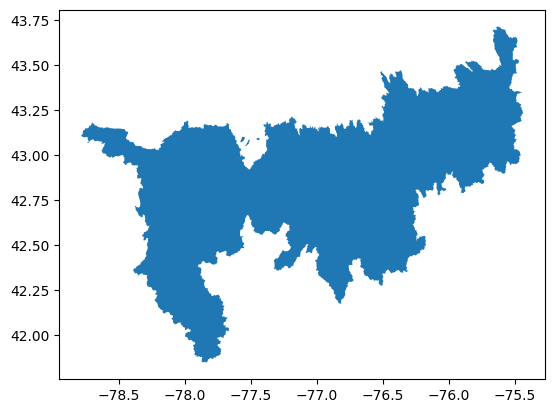

In [100]:
# Lets get the streamflow data, which may be good to add below the map
flow = NWIS().get_streamflow(station_id, dates = ('1900-01-01', '2022-12-31'))
flow.index = pd.to_datetime(flow.index)

## Now we need to get the geospatial data
nldi = NLDI()

# Get the watershed boundary
watershed_boundary = nldi.get_basins(station_id)

# Plot the watershed boundary to make sure it worked
watershed_boundary.plot()

Great, we've got the watershed boundary, now we also want to get the actual stream lines inside the basin.  

The `pynhd` library let's us do this using the `navigate_byid` function.  We will do this for the main stream and the tributaries separately. 


In [107]:
# Get the main rivers
main_rivers = nldi.navigate_byid(fsource='nwissite', 
                                 fid=f'USGS-{station_id}', 
                                 source='flowlines', 
                                 distance=distance,
                                 navigation='upstreamMain')


# Get the tributaries
tributary_rivers = nldi.navigate_byid(fsource='nwissite', 
                                      fid=f'USGS-{station_id}',
                                      source='flowlines',
                                      distance=distance, 
                                      navigation='upstreamTributaries')


tributary_rivers = tributary_rivers.simplify(0.001)

Let's add all the stream lines to a plot with the watershed boundary!

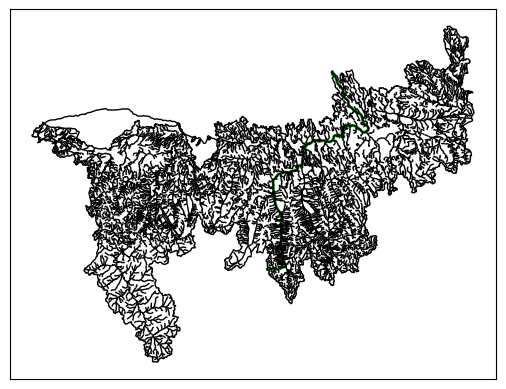

In [108]:
# Start the figure
fig, ax = plt.subplots()

# Add the watershed boundary (set ax=ax to add to the existing figure)
watershed_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Add main river
main_rivers.plot(ax=ax, color='green', linewidth=1)

# Add tributaries 
tributary_rivers.plot(ax=ax, color='black', linewidth=1)

# Other aesthetics changes and showing the plot
# plt.axis('off')
plt.xticks([])
plt.yticks([])

# Save the figure as an SVG
plt.savefig(f'./Figures/watershed_map.svg')
plt.show()

***



## Ridgeline Map

So, hopefully your watershed looks appealing.  

Although we have another artistic plot that we can create called a "Ridge plot".  These types of plots are often inspired by the band "Joy Division" and their iconic album art cover:

![Joy Division Cover Art](https://www.typeroom.eu/assets/original/2020/05/18/JoyDivision-UnknownPleasures-B1.jpg)


To make the ridge plot, we are going to need to specify a "bounded box".  This is essentially a set of coordinates that defines a box of interest on a map. 

In this case, you should find a box that is around your case study location.  


Use this website to determine the coordinates of the bounded box around your region of interest: [bboxfinder.com/]( http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000)


Once you retrieve the coordinates, you should save them in a variable that looks like this:

`ithaca = (-76.613500,42.368285,-76.347816,42.526367)`

In [ ]:
# Install the ridge_map package
!pip install ridge_map

In [ ]:
my_box = (0,0,0,0)

In [ ]:
from ridge_map import RidgeMap

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Define a custom colormap
def create_water_colormap(water_level=0.15, land_cmap='copper', water_color = (0.31, 0.769, 0.929,1)):
    """
    Create a colormap that colors low elevations as water and uses a terrain map for higher elevations.
    """

    # landsurface cmap
    terrain_map = plt.get_cmap(land_cmap)

    # default colors
    colors = terrain_map(np.linspace(0, 1, 256))

    # lower part fraction water
    water_end = int(256 * water_level)
    for i in range(water_end):
        colors[i] = water_color

    # new cmap w/ modified colors
    return LinearSegmentedColormap.from_list("custom_terrain", colors, N=256)

relative_water_level = 0.12  ## NEED TO TUNE THIS FOR EACH LOCATION

# Instantiate the colormap
custom_cmap = create_water_colormap(water_level=relative_water_level,
                                    land_cmap = 'bone')
## good land cmap options: 'twilight_shifted', 'gist_earth'


# Get bbox coords here: http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000
ithaca = (-76.613500,42.368285,-76.347816,42.526367)

abq = (-106.979541,34.390139,-106.029397,35.466486)
finger_lakes = (-77.895952,42.334590,-76.102762,43.045207)
mt_hood = (-122.806435,44.505908,-120.994022,47.295624)
caldera = (-106.730010,35.795427,-106.350364,36.026223)
keuka = (-77.286165,42.380865,-76.970365,42.685464)
treman =(-76.608304,42.391161,-76.543771,42.415245)
cayuga = (-76.856309,42.416968,-76.491080,43.011275)
cabezon = (-107.131487,35.574096,-107.059059,35.625321)
pepacton = (-75.049420,42.012264,-74.618972,42.196681)
shasta = (-122.536486,40.706877,-122.040132,40.941735)

rm = RidgeMap(shasta)

values = rm.get_elevation_data(num_lines=175)

values=rm.preprocess(
    values=values,
    lake_flatness=0,
    water_ntile=0,   ## keep this at 0 if you want to color the water lines
    vertical_ratio=140)

rm.plot_map(values=values,
            label='Shasta Reservoir, California',
            label_y=0.1,
            label_x=0.55,
            label_size=25,
            kind='elevation',
            line_color= custom_cmap,  #plt.get_cmap('Blues'),
            linewidth=1)